# 7-2. Nested Cross-Validation for Random Forest Regression Model's hyperparameter: `max_depth`

In this implementation, `nested cross-validation` is performed with an inner loop to tune hyperparameters and an outer loop to evaluate model performance. The inner loop tests different `max depth` values using `k-fold cross-validation` and selects the best value `based on mean squared error (MSE)`. The outer loop then trains the model with the optimal hyperparameter and evaluates it on the outer validation set, repeating this process across folds to compute the average MSE and standard deviation.

## Part a: Data import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

df_y2 = pd.read_csv('../data/train_test/rf_data_Y2.csv')
df_y3 = pd.read_csv('../data/train_test/rf_data_Y3.csv')

In [2]:
# get features and label from the the data
X_y2 = df_y2.drop(['DaysInHospital'], axis=1)
y_y2 = df_y2['DaysInHospital']

X_y3 = df_y3.drop(['DaysInHospital'], axis=1)
y_y3 = df_y3['DaysInHospital'] 

In [3]:
X_y3

,AgeAtFirstClaim,ClaimsCount,Unique_ProviderID,Unique_Vendor,PayDelay,Diagnostic Imaging,Emergency,General Practice,Internal,Surgery,...,TRAUMA,1-2,EM,MED,PL,RAD,SDS,0- 1 month,DrugCount,LabCount
0,35.0,4.0,2.0,2.0,143.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,5.0,1.0
1,5.0,11.0,3.0,1.0,379.0,0.0,0.0,0.0,9.0,0.0,...,0.0,11.0,8.0,3.0,0.0,0.0,0.0,5.0,6.0,0.0
2,5.0,13.0,4.0,3.0,563.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,6.0,2.0,1.0,4.0,0.0,5.0,10.0,1.0
3,15.0,8.0,7.0,7.0,330.0,1.0,3.0,0.0,1.0,1.0,...,0.0,0.0,2.0,0.0,2.0,1.0,1.0,8.0,2.0,2.0
4,5.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49677,15.0,2.0,1.0,1.0,62.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
49678,55.0,2.0,1.0,1.0,35.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,22.0,0.0
49679,0.0,18.0,6.0,5.0,561.0,2.0,0.0,0.0,14.0,2.0,...,0.0,18.0,9.0,4.0,0.0,3.0,2.0,3.0,35.0,0.0
49680,25.0,8.0,3.0,3.0,0.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,3.0,0.0,2.0,1.0,0.0,8.0,0.0,10.0


## Part b: Implement k-fold cross validation and nested cross validation

Nested cross validation was implemented using k-fold (3) cross validation and 20 independent replicates were run in order to calculate the mean/variance to properly compare the algorithms to obtain the best hyperparameters.

In [4]:
def k_fold_cross_validation(X, y, k, model):
    """
    Implement k-fold cross validation.

    Parameters:
    X: feature dataset.
    y: label dataset.
    k: number of folds (k in k-fold).
    model: model to be trained (model trained on each fold).

    Return value:
    Returns the mean and standard deviation of the mean squared error (MSE).
    """
    np.random.seed(42)
    fold_size = len(X) // k  # Size of each fold
    indices = np.random.permutation(len(X))  # Randomly shuffle the dataset
    mse_scores = []  # Store the MSE of each fold

    # Perform k-fold cross validation
    for i in range(k):
        val_indices = indices[i * fold_size: (i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])

        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        # Train the model and make predictions
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_scores.append(mse)

    # Return the mean and standard deviation of the mean square error
    return np.mean(mse_scores), np.std(mse_scores)

# Step 3: Implement nested cross validation and return the optimal hyperparameters
def nested_cross_validation(X, y, outer_k=3, inner_k=3, param_grid=None):
    """
    Implements nested cross validation for hyperparameter tuning and model evaluation.

    Parameters:
    X: feature dataset.
    y: label dataset.
    outer_k: the number of folds for the outer k-fold cross validation.
    inner_k: the number of folds for the inner k-fold cross validation, used for hyperparameter tuning.
    param_grid: hyperparameter grid, default is None.

    Return value:
    Returns the mean and standard deviation of the mean squared error (MSE) on the outer validation set, 
    as well as the optimal hyperparameter combination.
    """
    if param_grid is None:
        param_grid = {'max_depth': [5, 10, 15, None]}  # Adjust max_depth only

    outer_mse_scores = []
    best_params = None
    best_mse = float('inf')

    np.random.seed(42)
    indices = np.random.permutation(len(X))
    fold_size_outer = len(X) // outer_k

    for i in range(outer_k):
        val_indices_outer = indices[i * fold_size_outer:(i + 1) * fold_size_outer]
        train_indices_outer = np.concatenate([indices[:i * fold_size_outer], indices[(i + 1) * fold_size_outer:]])

        X_train_outer, X_val_outer = X.iloc[train_indices_outer], X.iloc[val_indices_outer]
        y_train_outer, y_val_outer = y.iloc[train_indices_outer], y.iloc[val_indices_outer]

        for max_depth in param_grid['max_depth']:
            model = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=42, n_jobs=-1)  # Fixed n_estimators, vary max_depth

            # Perform k-fold cross validation on the inner layer
            mean_mse, _ = k_fold_cross_validation(X_train_outer, y_train_outer, inner_k, model)

            if mean_mse < best_mse:
                best_mse = mean_mse
                best_params = {'max_depth': max_depth}

        # Use the optimal hyperparameters to train the final model on the outer training set
        final_model = RandomForestRegressor(n_estimators=180, max_depth=best_params['max_depth'], random_state=42, n_jobs=-1)
        final_model.fit(X_train_outer, y_train_outer)
        y_pred_outer = final_model.predict(X_val_outer)
        mse_outer = mean_squared_error(y_val_outer, y_pred_outer)
        outer_mse_scores.append(mse_outer)

    return np.mean(outer_mse_scores), np.std(outer_mse_scores), best_params


# Step 4: Modify run_multiple_experiments to return the optimal hyperparameters
def run_multiple_experiments(X, y, repetitions=20, outer_k=3, inner_k=3, param_grid=None):
    """
    Perform multiple nested cross-validation experiments, 
    returning the best hyperparameters and the mean and variance of the MSE for all experiments.
    """
    mse_results = []
    best_params_list = []

    for i in range(repetitions):
        print(f"Running repetition {i+1}/{repetitions}")
        mean_mse, std_mse, best_params = nested_cross_validation(X, y, outer_k=outer_k, inner_k=inner_k, param_grid=param_grid)
        mse_results.append(mean_mse)
        best_params_list.append(best_params)

    # Return the MSE mean and variance of all experiments and the best hyperparameters
    return np.mean(mse_results), np.std(mse_results), best_params_list


# Step 5: Perform 20 nested cross validation experiments to find the best hyperparameters for max_depth
param_grid = {'max_depth': [5, 10, 15, 20, None]}  # Adjust max_depth only
mean_mse, std_mse, best_params_list = run_multiple_experiments(X_y2, y_y2, repetitions=20, param_grid=param_grid)

# Output results
print(f"Mean MSE after 20 repetitions: {mean_mse}")
print(f"Standard deviation of MSE after 20 repetitions: {std_mse}")
print(f"Best hyperparameters for each run: {best_params_list}")


Running repetition 1/20
Running repetition 2/20
Running repetition 3/20
Running repetition 4/20
Running repetition 5/20
Running repetition 6/20
Running repetition 7/20
Running repetition 8/20
Running repetition 9/20
Running repetition 10/20
Running repetition 11/20
Running repetition 12/20
Running repetition 13/20
Running repetition 14/20
Running repetition 15/20
Running repetition 16/20
Running repetition 17/20
Running repetition 18/20
Running repetition 19/20
Running repetition 20/20
Mean MSE after 20 repetitions: 0.7063454048429556
Standard deviation of MSE after 20 repetitions: 1.1102230246251565e-16
Best hyperparameters for each run: [{'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_depth': 10}, {'max_dept

The nested cross-validation results show that the best value for max depth is always 10 across all 20 repetitions. The average MSE (mean squared error) is 0.706345 with a standard deviation of 1.1102230246251565e-16, indicating that the performance of the model is highly stable and consistent across all iterations. The lack of change in MSE indicates that the model has good generalization ability and that 10 is a robust choice for max depth in this random forest configuration.

## Part c: Finding better hyperparameters

Center on the best known hyperparameters and see if there are better values ​​in the range.

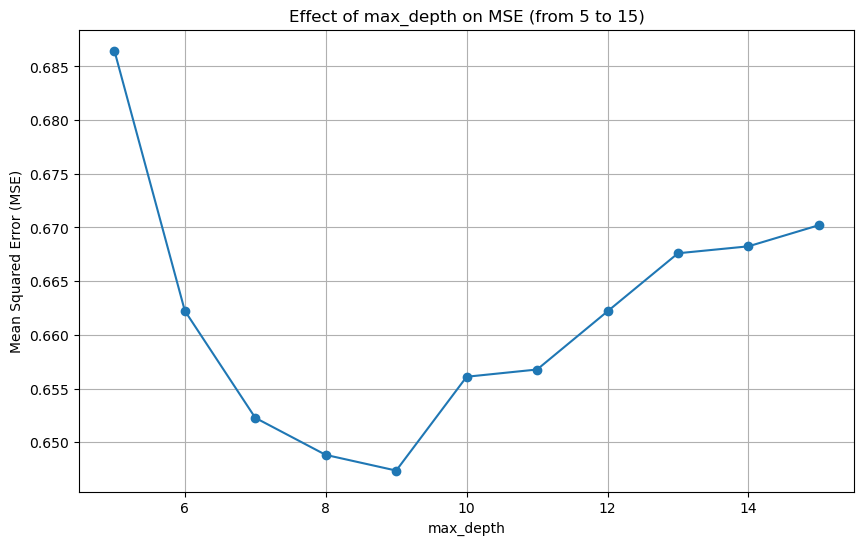

In [5]:
# Define the range of max_depth, from 5 to 15
max_depth_range = list(range(5, 16))

# Store the MSE corresponding to each max_depth
mse_values = []

#Traverse different max_depth values, train the model and calculate MSE
for max_depth in max_depth_range:
    model = RandomForestRegressor(max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_y2, y_y2)
    y_pred_y3 = model.predict(X_y3)
    mse_y3 = mean_squared_error(y_y3, y_pred_y3)
    mse_values.append(mse_y3)

# Draw a line chart of max_depth and MSE
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, mse_values, marker='o')
plt.title('Effect of max_depth on MSE (from 5 to 15)')
plt.xlabel('max_depth')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.show()


max depth: 9 is found as a better hyperparameter.

## Part c: Using best hyperparameter to tran the model, and compare with default model

The model is trained using the data from the second year and the optimal hyperparameters, and predictions and model performance evaluation are performed using the data from the third year.

In [6]:
# Use the optimal hyperparameters to train the final model and make predictions
final_model = RandomForestRegressor(max_depth= 9, random_state=42, n_jobs=-1)
final_model.fit(X_y2, y_y2)
y_pred_y3 = final_model.predict(X_y3)

# Evaluate the model's performance on the third year's data
mse_y3 = mean_squared_error(y_y3, y_pred_y3)
print(f"Mean Squared Error on Year 3 data(hyperparameter changed model): {mse_y3}")


Mean Squared Error on Year 3 data(hyperparameter changed model): 0.6473559787410311


In [7]:
# Use the default hyperparameters to train the final model and make predictions
final_model = RandomForestRegressor(random_state=42, n_jobs=-1)
final_model.fit(X_y2, y_y2)
y_pred_y3 = final_model.predict(X_y3)

# Evaluate the model's performance on the third year's data
mse_y3 = mean_squared_error(y_y3, y_pred_y3)
print(f"Mean Squared Error on Year 3 data(default model): {mse_y3}")

Mean Squared Error on Year 3 data(default model): 0.6783336540396924


By adjusting the max_depth hyperparameter, the model's performance on the third year data improved. The mean square error (MSE) for the third year data was reduced to 0.6473, while the MSE was 0.6783 when using the default hyperparameters.

This shows that on this particular dataset, the optimized hyperparameter model can better fit the third year data and reduce the prediction error compared to the default model.